All functions are delivered in the reactiv.py file

In [1]:
# replace here by the import of reactiv.py
from reactiv import *

In [2]:
import os
import cv2
import sys
import glob
from glob import glob
import numpy as np
import rasterio
import rasterio.features
import rasterio.warp


import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline

In [3]:
from pathlib import Path

DATA_PATH = Path("/home/cloud-user/work/data/acousur")

# DATA IMPORT  

In this section, we initialize the input data required for processing by the software. These data take the form of multi-dimensional arrays (ndarrays) from the Numpy library, specifically structured to represent time series from radar data.

Each time series is organized into a three-dimensional stack whose dimensions correspond to :

    Nt (temporal dimension): The total number of radar images in the series, equivalent to the number of acquisition dates available.
    Nx (Spatial dimension - X axis): The number of horizontal pixels in each radar image.
    Ny (Spatial dimension - Y axis): The number of vertical pixels in each radar image.

Thus, the stack structure is defined by Nt×Nx×NyNt×Nx×Ny.

Essential pre-processing: Before applying the software, it is crucial that these stacks are rigorously re-aligned to ensure precise spatial alignment between successive images. In the practical example proposed in this notebook, we use data stacks that have been pre-registered using GeFolki, a specific registration code.

The source data for the stacks comes from UAVSAR images over San Francisco, which are accessible as OpenSource data and are part of the "Single Look Complex" (SLC) product level.

Polarimetric channel organization: It is necessary to define a separate ndarray for each of the polarimetric channels available. If, for example, we have the polarimetric components HH, HV and VV, we'll need three separate Numpy arrays, each corresponding to one of these channels.


In [4]:
# Replace by our own data
Exx = np.load(DATA_PATH / '2020_VH.npy')
Eyy = np.load(DATA_PATH / '2020_VV.npy')
print('Size of the Stack: ', 'xx:', np.shape(Exx),'yy:', np.shape(Eyy), )

Size of the Stack:  xx: (29, 3109, 5176) yy: (29, 3109, 5176)


In [5]:
Nt,nx,ny=np.shape(Exx)

## Test on amplitudes

 Here we define the stack for each polarimetric channel in intensities

In [6]:
p0=np.abs(Exx)**2
p2=np.abs(Eyy)**2
P3=[p0,p2]
p=len(P3)

We compute each individual coefficient of variations, one by polarimetric channel

In [11]:
CVHH=Stack2SingleCV(p0,timeaxis=0)
CVVV=Stack2SingleCV(p2,timeaxis=0)

In [12]:
Lmin3,Lmax3=CV_Generalized_Limits(P3)

  0%|          | 0/3109 [00:00<?, ?it/s]

100%|██████████| 3109/3109 [34:35<00:00,  1.50it/s]


In [18]:
def renormalize_matrix(M,p1,p2):
    """
    Renormalize the values of a matrix between 0 and 1, where 0 corresponds to the 1st percentile
    and 1 corresponds to the 99th percentile.

    Parameters:
    - M: Input matrix.

    Returns:
    - M_normalized: Renormalized matrix.
    """
    # Calcul des percentiles 1 et 99
    percentile_1 = np.percentile(M, p1)
    percentile_2 = np.percentile(M, p2)

    # Renormalisation entre 0 et 1
    M_normalized = (M - percentile_1) / (percentile_2 - percentile_1)

    # Assurer que les valeurs sont limitées entre 0 et 1 (au cas où)
    M_normalized = np.clip(M_normalized, 0, 1)

    return M_normalized

In [20]:
Lmin3

array([[0.04613606, 0.04700381, 0.0365819 , ..., 0.05587925, 0.07314645,
        0.1785312 ],
       [0.03409003, 0.03767374, 0.05112461, ..., 0.1057108 , 0.18254362,
        0.20066996],
       [0.03328237, 0.03928241, 0.05778668, ..., 0.15862733, 0.17145494,
        0.18009722],
       ...,
       [0.13084077, 0.14740851, 0.11041412, ..., 0.04580911, 0.0502497 ,
        0.05889081],
       [0.12383367, 0.09149614, 0.06913851, ..., 0.08123066, 0.10509312,
        0.08501107],
       [0.03727633, 0.03763222, 0.07266211, ..., 0.09928046, 0.13947168,
        0.07690385]], shape=(3109, 5176))

In [34]:
np.save("Lmax3.npy", Lmax3)

In [5]:
Lmax3 = np.load("Lmax3.npy")
Lmin3 = np.load("Lmin3.npy")

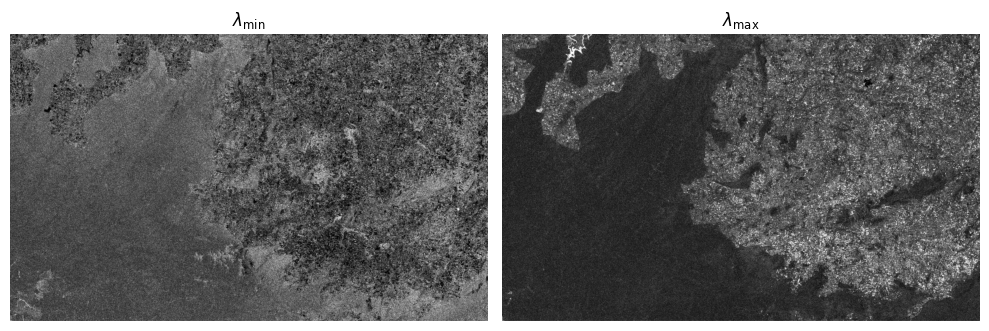

In [9]:
import cv2
# Image dimensions (height, width)
height, width = Lmin3.shape
resize_factor = 3
new_size = (width // resize_factor, height // resize_factor)  # OpenCV: (width, height)

# Resize the images
img_min = renormalize_matrix(Lmin3, 2, 98)
img_max = renormalize_matrix(Lmax3, 2, 98)

img_min_resized = cv2.resize(img_min, new_size, interpolation=cv2.INTER_AREA)
img_max_resized = cv2.resize(img_max, new_size, interpolation=cv2.INTER_AREA)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

axs[0].imshow(img_min_resized, cmap='gray')
axs[0].set_title(r"$\lambda_{\min}$")
axs[0].axis('off')

axs[1].imshow(img_max_resized, cmap='gray')
axs[1].set_title(r"$\lambda_{\max}$")
axs[1].axis('off')

plt.tight_layout()
plt.show()


Compute classical coefficients of variation

In [16]:
CVRR, CVgv, CVVN, CVAZ =CV_fromListofImages(P3)

Compute intermediate MCV (Multivariate Coefficients of variation)

In [17]:
CV1=CV_Generalized_equally(P3,1)  # you can check CVgv = CV1   CV0 = CVRR 
CVne1=CV_Generalized_Non_equally(P3,1)  # you can check CVne1 = CVAZ
CVnemoins1=CV_Generalized_Non_equally(P3,-1) # you can check CVne-1 = CVVN
CV_ne0=CV_Generalized_Non_equally_Zero(P3)


  0%|          | 4/3109 [00:03<40:55,  1.26it/s]/mnt/data/Acousur/REACTIV/Python/reactiv.py:441: RuntimeWarning: overflow encountered in power
  result=(np.prod(eigenvalues**(np.abs(muprime)**2)))**(1/normMU**2)
100%|██████████| 3109/3109 [35:36<00:00,  1.46it/s]


In [39]:
np.save("CV_ne0.npy", CV_ne0)

In [ ]:
import numpy as np

CV = np.load("CV_ne0.npy")
CV1 = np.load("CV1.npy")


array([[0.81961832, 1.03171978, 1.18597487, ..., 0.74788651, 0.61653299,
        0.68304324],
       [1.05133088, 1.02516635, 1.06621326, ..., 0.77739554, 0.67677269,
        0.76741598],
       [1.11190977, 1.1003175 , 0.83001624, ..., 0.69753303, 0.77952219,
        0.91310543],
       ...,
       [0.88461213, 0.98260265, 1.1991592 , ..., 1.08666358, 0.80572876,
        0.8702937 ],
       [0.87287338, 1.18099817, 2.29047838, ..., 0.89975567, 0.88454162,
        0.72907134],
       [2.17894145, 2.13613806, 2.84021599, ..., 1.65300013, 1.4529615 ,
        1.69959732]], shape=(3109, 5176))

# Comparison Jones Amplitudes and Stokes

In [12]:
def Jones2Stokes(Ex, Ey):
    """
    Convert Jones vectors to Stokes parameters.
    Args:
        Ex (numpy.ndarray): Electric field component in the x-direction over time and space.
                           Dimensions: (nt, nx, ny)
        Ey (numpy.ndarray): Electric field component in the y-direction over time and space.
                           Dimensions: (nt, nx, ny)
    Returns:
        tuple: A tuple containing four matrices representing the Stokes parameters:
            - S0 (numpy.ndarray): Total intensity. Dimensions: (nt, nx, ny)
            - S1 (numpy.ndarray): Stokes parameter S1. Dimensions: (nt, nx, ny)
            - S2 (numpy.ndarray): Stokes parameter S2. Dimensions: (nt, nx, ny)
            - S3 (numpy.ndarray): Stokes parameter S3. Dimensions: (nt, nx, ny)
    """
    # Calculate Stokes parameters
    S0 = np.abs(Ex)**2 + np.abs(Ey)**2
    S1 = np.abs(Ex)**2 - np.abs(Ey)**2
    S2 = 2 * np.real(Ex * np.conj(Ey))
    S3 = 2 * np.imag(Ex * np.conj(Ey))

    return S0, S1, S2, S3

def Stokes2Intensities(S0,S1,S2,S3):
    """
    Convert Stokes parameters into positive intensities.
    Args:
        Si (numpy.ndarray): Stokes components   Dimensions: (nt, nx, ny)
    Returns:
        tuple: A tuple containing four matrices representing the Intensities parameters:
            - Ii (numpy.ndarray): Positive Intensity. Dimensions: (nt, nx, ny)

    """
    # Calculate Stokes parameters
    I0=S0+1/np.sqrt(3)*S1+1/np.sqrt(3)*S2+1/np.sqrt(3)*S3
    I1=S0+1/np.sqrt(3)*S1-1/np.sqrt(3)*S2-1/np.sqrt(3)*S3
    I2=S0-1/np.sqrt(3)*S1-1/np.sqrt(3)*S2+1/np.sqrt(3)*S3
    I3=S0-1/np.sqrt(3)*S1+1/np.sqrt(3)*S2-1/np.sqrt(3)*S3

    return I0, I1, I2, I3

S0, S1, S2, S3=Jones2Stokes(Exx,Eyy)
I0, I1, I2, I3=Stokes2Intensities(S0, S1,S2,S3)


: 

In [41]:
I0 = np.load(DATA_PATH / "2020_I0.npy")
I1 = np.load(DATA_PATH / "2020_I1.npy")
I2 = np.load(DATA_PATH / "2020_I2.npy")
I3 = np.load(DATA_PATH / "2020_I3.npy")

In [ ]:
P=[I0,I1,I2,I3]

: 

In [ ]:
Lmin,Lmax = CV_Generalized_Limits(P)
fig, axs = plt.subplots(1, 2, figsize=(4.5, 3))
p1=1
p2=98
axs[0].imshow(cv2.resize(renormalize_matrix(Lmin,p1,p2),(ny//3,nx), interpolation=cv2.INTER_AREA),cmap='gray')
axs[0].set_title('$\lambda_{{\min}}$')
axs[0].axis('off')
axs[1].imshow(cv2.resize(renormalize_matrix(Lmax,p1,p2),(ny//3,nx), interpolation=cv2.INTER_AREA),cmap='gray')
axs[1].set_title('$\lambda_{{\max}}$')
axs[1].axis('off')
plt.tight_layout()

<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:9: SyntaxWarning: invalid escape sequence '\l'
<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:9: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_287743/2713336943.py:6: SyntaxWarning: invalid escape sequence '\l'
  axs[0].set_title('$\lambda_{{\min}}$')
/tmp/ipykernel_287743/2713336943.py:9: SyntaxWarning: invalid escape sequence '\l'
  axs[1].set_title('$\lambda_{{\max}}$')
  0%|          | 0/3109 [00:00<?, ?it/s]/mnt/data/Acousur/REACTIV/Python/reactiv.py:368: RuntimeWarning: invalid value encountered in sqrt
  limitmin_per_pixel[x, y] = np.sqrt(np.min(eigenvalues))/normMU
  0%|          | 6/3109 [00:05<49:17,  1.05it/s]  


KeyboardInterrupt: 

In [8]:
np.save("Lmin.npy", Lmin)
np.save("Lmax.npy", Lmax)

In [16]:
p0=np.abs(Exx)**2
p1=np.abs(Eyy)**2
P2=[p0,p1]
Lmin2,Lmax2=CV_Generalized_Limits(P2)

KeyboardInterrupt: 

In [12]:
np.save("Lmin2.npy", Lmin2)
np.save("Lmax2.npy", Lmax2)

In [ ]:
Lmin2 = np.load("Lmin2.npy")
Lmax2 = np.load("Lmax2.npy")

<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_287743/303958657.py:5: SyntaxWarning: invalid escape sequence '\l'
  axs[0].set_title('$\lambda_{{\max}}$ with phase')
/tmp/ipykernel_287743/303958657.py:8: SyntaxWarning: invalid escape sequence '\l'
  axs[1].set_title('$\lambda_{{\max}}$ incoherent')


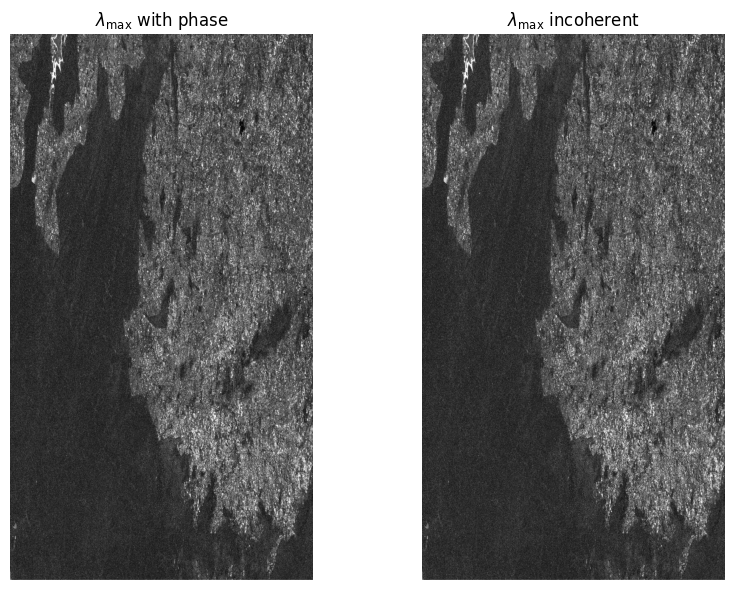

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(9, 6))
p1=1
p2=98
axs[0].imshow(cv2.resize(renormalize_matrix(Lmax,p1,p2),(ny//3,nx), interpolation=cv2.INTER_AREA),cmap='gray')
axs[0].set_title('$\lambda_{{\max}}$ with phase')
axs[0].axis('off')
axs[1].imshow(cv2.resize(renormalize_matrix(Lmax2,p1,p2),(ny//3,nx), interpolation=cv2.INTER_AREA),cmap='gray')
axs[1].set_title('$\lambda_{{\max}}$ incoherent')
axs[1].axis('off')
plt.tight_layout()

# Analyzis for one pixel

In [23]:
def Analyse_matrixC(P,x,y):
    p=len(P)
    Nt=P[0].shape[0]
    pixel_series = np.array([[P[i][t, x, y] for t in range(Nt)] for i in range(p)])
    # Calculate the covariance matrix for this pixel series
    C = np.cov(pixel_series)*(Nt-1)/Nt
    mu=np.mean(pixel_series,axis=1)
    normMU=np.linalg.norm(mu)
    valeurs_propres, vecteurs_propres = np.linalg.eig(C)

    print('matrice C: ', C/np.trace(C))
    print('valeurs propres normalisees', valeurs_propres/np.trace(C))
    print('vecteurs propres ', vecteurs_propres)

    plt.figure()
    for i in range(len(pixel_series)):
        plt.plot(pixel_series[i], 'o',linestyle='--',markersize=4, label=f'Canal {i+1}')
    plt.legend()
    
    NQ=30
    CVeq=tableau = [0] * (2*NQ+1)
    CVne=tableau = [0] * (2*NQ+1)

    for k,Q in enumerate(range(-NQ,NQ+1)):
        if Q!=0:
            CQ=np.linalg.matrix_power(C, Q) # COvariance Matrix power Q
            toto=np.sqrt((1/p*np.trace(CQ))**(1/Q))/normMU
            CVeq[k]=np.sqrt((1/p*np.trace(CQ))**(1/Q))/normMU
        
            mu=np.mean(pixel_series,axis=1)
            normMU=np.linalg.norm(mu)
            intermediate_result = np.dot(mu.T, CQ)
            result = np.dot(intermediate_result, mu)
            CVne[k]=np.sqrt((1/1*result)**(1/Q))/normMU**(1+1/Q)
        else:
            CVeq[k]=np.sqrt(np.linalg.det(C)**(1/p))/normMU
            mu=np.mean(pixel_series,axis=1)
            normMU=np.linalg.norm(mu)
            eigenvalues,U= np.linalg.eig(C)
            muprime=np.dot(U.T,mu)
            result=(np.prod(eigenvalues**(np.abs(muprime)**2)))**(1/normMU**2)
            CVne[k]=np.sqrt(result)/normMU
    plt.figure()
    plt.plot(range(-NQ,NQ+1),CVeq,color='k')
    plt.plot(range(-NQ,NQ+1),CVne,color='gray')
    plt.axhline(y=np.sqrt(np.max(valeurs_propres))/normMU, color='r', linestyle='-')
    plt.axhline(y=np.sqrt(np.min(valeurs_propres))/normMU, color='b', linestyle='-')
    plt.plot(0, CVeq[NQ], 'o', markersize=8,color='k')
    plt.plot(1, CVeq[NQ+1], 'o', markersize=8,color='k')
    plt.plot(1, CVne[NQ+1], 'o', markersize=8,color='gray')
    plt.plot(0, CVne[NQ], 'o', markersize=8,color='gray')
    plt.plot(-1, CVne[NQ-1], 'o', markersize=8,color='gray')


matrice C:  [[0.05236224 0.02957958 0.13468423 0.15746689]
 [0.02957958 0.02305086 0.09698259 0.10351131]
 [0.13468423 0.09698259 0.41646484 0.45416648]
 [0.15746689 0.10351131 0.45416648 0.50812206]]
valeurs propres normalisees [9.87495276e-01 1.23789685e-02 1.25755044e-04 3.60790838e-17]
vecteurs propres  [[-0.21833967  0.65130766  0.52737664  0.5       ]
 [-0.1485263  -0.30968122  0.79500785 -0.5       ]
 [-0.64620666 -0.57574689 -0.03053641  0.5       ]
 [-0.71602003  0.38524199 -0.29816762 -0.5       ]]


/home/cloud-user/miniconda3/envs/acousur/lib/python3.12/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/tmp/ipykernel_287743/3025490349.py:34: RuntimeWarning: invalid value encountered in scalar power
  CVne[k]=np.sqrt((1/1*result)**(1/Q))/normMU**(1+1/Q)


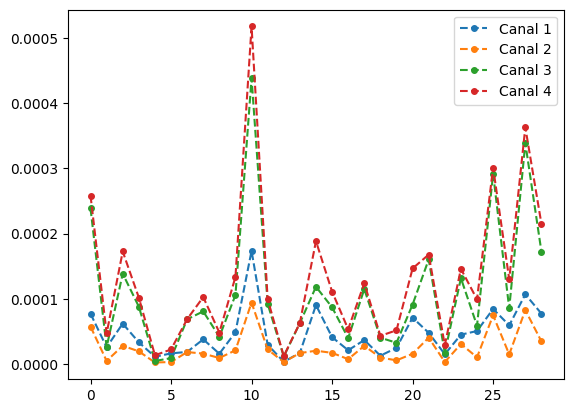

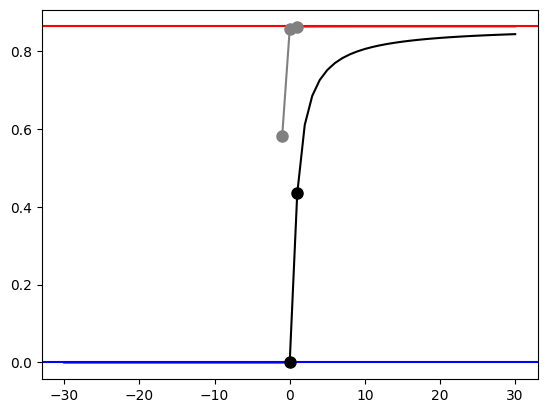

In [24]:
Analyse_matrixC(P,103,761)

## Analysis of profiles in Pauli basis

In [8]:
def PlotProfilesPauli(P,x,y):
    p=len(P)
    Nt=P[0].shape[0]
    pixel_series = np.array([[P[i][t, x, y] for t in range(Nt)] for i in range(p)])
    
    plt.rcParams['font.size'] = 14 # Taille de police globale
    plt.rcParams['axes.labelsize'] = 14 # Taille de police pour les labels des axes
    plt.rcParams['axes.titlesize'] = 16 # Taille de police pour les titres
    plt.rcParams['xtick.labelsize'] = 14 # Taille de police pour les labels des ticks sur l'axe des x
    plt.rcParams['ytick.labelsize'] = 14 # Taille de police pour les labels des ticks sur l'axe des y
    plt.rcParams['legend.fontsize'] = 14 # Taille de police pour la légende


    plt.figure()
    plt.plot(pixel_series[0], 'o',linestyle='--',color='b',markersize=6, label=f'Intensity Profile: HH-VV')
    plt.plot(pixel_series[1], 'x',linestyle='--',color='g',markersize=6, label=f'Intensity Profile: 2 HV')
    plt.plot(pixel_series[2], 's',linestyle='--',color='r',markersize=6, label=f'Intensity Profile: HH+VV')
    plt.title('$\lambda_{\min}$'+'={:.2f}'.format(Lmin3[x,y])+'$~~  \lambda_{\max}$'+'={:.2f}'.format(Lmax3[x,y]))
    plt.xlabel('Number of Acquisition')
    plt.legend()
    #plt.savefig('ex103.png', dpi=300)

<>:18: SyntaxWarning: invalid escape sequence '\l'
<>:18: SyntaxWarning: invalid escape sequence '\l'
<>:18: SyntaxWarning: invalid escape sequence '\l'
<>:18: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_288036/1446242227.py:18: SyntaxWarning: invalid escape sequence '\l'
  plt.title('$\lambda_{\min}$'+'={:.2f}'.format(Lmin3[x,y])+'$~~  \lambda_{\max}$'+'={:.2f}'.format(Lmax3[x,y]))
/tmp/ipykernel_288036/1446242227.py:18: SyntaxWarning: invalid escape sequence '\l'
  plt.title('$\lambda_{\min}$'+'={:.2f}'.format(Lmin3[x,y])+'$~~  \lambda_{\max}$'+'={:.2f}'.format(Lmax3[x,y]))


In [10]:
p0=np.abs(Exx-Eyy)**2
p2=np.abs(Exx+Eyy)**2
P3=[p0,p2]

 #Lmin4,Lmax4=CV_Generalized_Limits(P3)

In [6]:
np.save("Lmin4.npy", Lmin4)
np.save("Lmax4.npy", Lmax4)

In [21]:
# To find specific behaviors
# indices = np.where((Lmin3<0.001)*(Lmax3>1))
# print("Indices", indices)
# Case Lmin low: 264 538, 263 128, 279 469
# Lmax high Lmin high 141 264, 79 991, 263 520

/tmp/ipykernel_288036/1446242227.py:18: SyntaxWarning: invalid escape sequence '\l'
  plt.title('$\lambda_{\min}$'+'={:.2f}'.format(Lmin3[x,y])+'$~~  \lambda_{\max}$'+'={:.2f}'.format(Lmax3[x,y]))
/tmp/ipykernel_288036/1446242227.py:18: SyntaxWarning: invalid escape sequence '\l'
  plt.title('$\lambda_{\min}$'+'={:.2f}'.format(Lmin3[x,y])+'$~~  \lambda_{\max}$'+'={:.2f}'.format(Lmax3[x,y]))


IndexError: index 2 is out of bounds for axis 0 with size 2

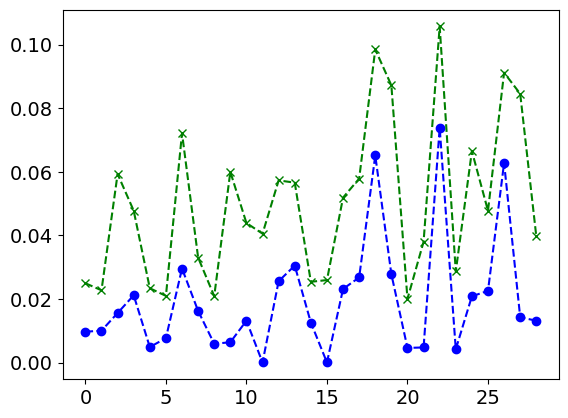

In [9]:
PlotProfilesPauli(P3,263,520)

In [7]:
import torch
import numpy as np

def CV_Generalized_Limits_GPU_Chunked(series_np, device='cuda', chunk_size=10000):
    """
    Memory-efficient PyTorch version of CV_Generalized_Limits using GPU and chunking.
    Inputs:
        - series_np: list of p numpy arrays of shape (Nt, nx, ny)
        - chunk_size: number of pixels to process per batch (tune depending on your GPU)
    Returns:
        - limit_min, limit_max: (nx, ny) arrays
    """
    # Stack input and send to device
    series = torch.tensor(np.stack(series_np), dtype=torch.float32)  # (p, Nt, nx, ny)
    p, Nt, nx, ny = series.shape
    N = nx * ny

    series = series.view(p, Nt, N)  # shape: (p, Nt, N)

    # Pre-allocate output arrays
    limit_min = torch.empty(N, device='cpu')
    limit_max = torch.empty(N, device='cpu')

    for start in range(0, N, chunk_size):
        end = min(start + chunk_size, N)
        idx = slice(start, end)

        # Move chunk to device
        series_chunk = series[:, :, idx].to(device)  # (p, Nt, chunk_size)

        # Compute mean and norm per pixel
        mu = series_chunk.mean(dim=1)  # (p, chunk_size)
        normMU = torch.norm(mu, dim=0)  # (chunk_size,)

        # Centered data
        centered = series_chunk - series_chunk.mean(dim=1, keepdim=True)  # (p, Nt, chunk_size)

        # Covariance for each pixel: (p, p, chunk_size)
        cov = torch.einsum('pti,qti->pqi', centered, centered) / Nt  # (p, p, chunk_size)
        cov = cov.permute(2, 0, 1)  # (chunk_size, p, p)

        # Eigendecomposition
        eigvals = torch.linalg.eigvalsh(cov)  # (chunk_size, p)

        eig_min = eigvals[:, 0]
        eig_max = eigvals[:, -1]

        # Keep eps very small
        eps = 1e-8

        # Clamp only *negative or zero* eigenvalues — NOT everything
        eig_min = torch.where(eig_min <= 0, torch.full_like(eig_min, eps), eig_min)
        eig_max = torch.where(eig_max <= 0, torch.full_like(eig_max, eps), eig_max)

        # Avoid divide-by-zero in normMU, but only where needed
        normMU = torch.where(normMU < eps, torch.full_like(normMU, eps), normMU)

        # Now compute
        lmin = torch.sqrt(eig_min) / normMU
        lmax = torch.sqrt(eig_max) / normMU

        # Move results to CPU and store
        limit_min[idx] = lmin.cpu()
        limit_max[idx] = lmax.cpu()

    # Reshape to (nx, ny)
    return limit_min.view(nx, ny).numpy(), limit_max.view(nx, ny).numpy()

In [11]:
Lmin4_gpu,Lmax4_gpu=CV_Generalized_Limits_GPU_Chunked(P3)

In [12]:
Lmin4_gpu, Lmax4_gpu

(array([[0.15490153, 0.15118264, 0.19535501, ..., 0.17386173, 0.18280566,
         0.21819077],
        [0.14043988, 0.15286353, 0.166347  , ..., 0.19837482, 0.21034002,
         0.236479  ],
        [0.12578525, 0.18443973, 0.16638383, ..., 0.21245414, 0.24820389,
         0.25698316],
        ...,
        [0.22048526, 0.23389316, 0.22725673, ..., 0.12882183, 0.15102838,
         0.15609515],
        [0.23935981, 0.24479619, 0.19930048, ..., 0.12468859, 0.21431161,
         0.1834079 ],
        [0.13103995, 0.16389343, 0.32174063, ..., 0.24313073, 0.32164377,
         0.25578895]], shape=(3109, 5176), dtype=float32),
 array([[0.757871  , 0.9627677 , 1.1405419 , ..., 0.68060714, 0.5572359 ,
         0.6324913 ],
        [0.98010695, 0.9563635 , 1.0290706 , ..., 0.6792283 , 0.5748354 ,
         0.7872495 ],
        [1.0638573 , 1.0529801 , 0.8439696 , ..., 0.6117693 , 0.64741695,
         0.9153858 ],
        ...,
        [0.9122125 , 0.96512496, 1.2203816 , ..., 0.999137  , 0.7677351 ,

In [ ]:
Lmin4, Lmax4

(array([[0.15490147, 0.15118259, 0.19535497, ..., 0.1738616 , 0.18280555,
         0.2181906 ],
        [0.14043982, 0.15286347, 0.16634695, ..., 0.19837466, 0.21033989,
         0.23647882],
        [0.1257852 , 0.18443967, 0.16638377, ..., 0.21245399, 0.24820377,
         0.256983  ],
        ...,
        [0.22048502, 0.23389295, 0.22725655, ..., 0.12882179, 0.15102832,
         0.15609509],
        [0.23935951, 0.24479598, 0.19930033, ..., 0.12468854, 0.21431154,
         0.18340784],
        [0.13103968, 0.16389318, 0.32174027, ..., 0.24313052, 0.3216435 ,
         0.25578877]], shape=(3109, 5176), dtype=float32),
 array([[0.75787073, 0.9627674 , 1.1405417 , ..., 0.6806066 , 0.55723554,
         0.6324908 ],
        [0.9801066 , 0.9563632 , 1.0290703 , ..., 0.67922777, 0.574835  ,
         0.7872489 ],
        [1.063857  , 1.0529797 , 0.8439693 , ..., 0.6117689 , 0.64741665,
         0.91538525],
        ...,
        [0.91221154, 0.9651241 , 1.2203807 , ..., 0.9991367 , 0.7677349 ,

In [4]:
Lmin4 = np.load("Lmin4.npy")
Lmax4 = np.load("Lmax4.npy")

In [ ]:
np.allclose(Lmin4, Lmin4_gpu)

False

In [14]:
np.allclose(Lmin4, Lmin4_gpu, rtol=1e-3, atol=1e-5)

False

In [15]:
diff = np.abs(Lmin4 - Lmin4_gpu)
print("Mean diff:", np.mean(diff))
print("Max diff:", np.max(diff))


Mean diff: 1.2583593893407784e-07
Max diff: 0.0014865937406709421


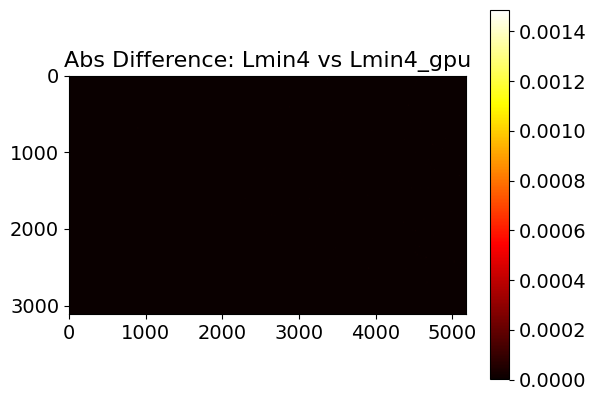

In [43]:
import matplotlib.pyplot as plt

plt.imshow(np.abs(Lmin4 - Lmin4_gpu), cmap='hot')
plt.colorbar()
plt.title("Abs Difference: Lmin4 vs Lmin4_gpu")
plt.show()

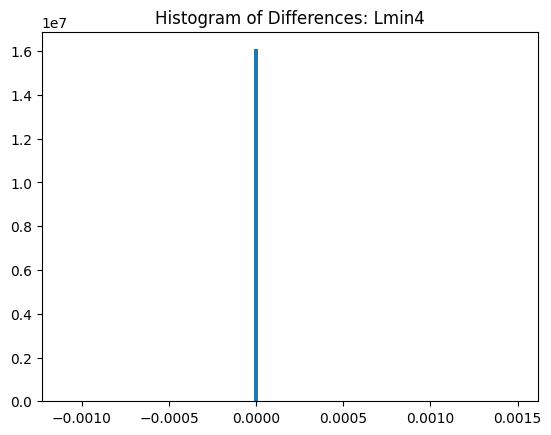

In [16]:
plt.hist((Lmin4 - Lmin4_gpu).ravel(), bins=100)
plt.title("Histogram of Differences: Lmin4")
plt.show()

In [39]:
diff = np.abs(Lmin4 - Lmin4_gpu)
coords = np.argwhere(diff > 1.0)  # or use np.argmax(diff)

for x, y in coords:
    print(f"Pixel ({x}, {y}): CPU={Lmin4[x, y]}, GPU={Lmin4_gpu[x, y]}, Diff={diff[x, y]}")

In [28]:
diff_mask = ~np.isclose(Lmin4_gpu, Lmin4, rtol=1e-4, atol=1e-6)
print("Pixels with difference >", np.sum(diff_mask))

Pixels with difference > 18139


In [26]:
diff.shape

(3109, 5176)

In [24]:
3109*5176

16092184

In [29]:
# Affiche les valeurs de Lmin4 et Lmin4_gpu là où elles diffèrent
print("Lmin4 (original) values:")
print(Lmin4[diff_mask])

print("\nLmin4_gpu (GPU) values:")
print(Lmin4_gpu[diff_mask])

# Optionnel : afficher la différence absolue
print("\nAbsolute differences:")
print(np.abs(Lmin4[diff_mask] - Lmin4_gpu[diff_mask]))

Lmin4 (original) values:
[0.03490099 0.04803061 0.01879936 ... 0.0374569  0.03991706 0.03810417]

Lmin4_gpu (GPU) values:
[0.03488502 0.04802454 0.01876657 ... 0.03744581 0.03991118 0.03809794]

Absolute differences:
[1.59660926e-05 6.06665347e-06 3.27918301e-05 ... 1.10827010e-05
 5.88419402e-06 6.23042207e-06]


In [31]:
diff_coords = np.argwhere(diff_mask)
print("Coordinates of differing pixels:")
print(diff_coords)

Coordinates of differing pixels:
[[   0  367]
 [   0 3629]
 [   0 4749]
 ...
 [3105 3943]
 [3108 3511]
 [3108 3800]]


In [32]:
for (x, y) in diff_coords:
    print(f"Pixel ({x}, {y}): Lmin4 = {Lmin4[x, y]:.6f}, Lmin4_gpu = {Lmin4_gpu[x, y]:.6f}, diff = {abs(Lmin4[x, y] - Lmin4_gpu[x, y]):.6e}")

Pixel (0, 367): Lmin4 = 0.034901, Lmin4_gpu = 0.034885, diff = 1.596609e-05
Pixel (0, 3629): Lmin4 = 0.048031, Lmin4_gpu = 0.048025, diff = 6.066653e-06
Pixel (0, 4749): Lmin4 = 0.018799, Lmin4_gpu = 0.018767, diff = 3.279183e-05
Pixel (0, 4750): Lmin4 = 0.015995, Lmin4_gpu = 0.015981, diff = 1.481941e-05
Pixel (0, 4751): Lmin4 = 0.018655, Lmin4_gpu = 0.018639, diff = 1.568889e-05
Pixel (0, 4754): Lmin4 = 0.032721, Lmin4_gpu = 0.032726, diff = 4.673360e-06
Pixel (0, 4755): Lmin4 = 0.016357, Lmin4_gpu = 0.016336, diff = 2.098429e-05
Pixel (0, 4756): Lmin4 = 0.005861, Lmin4_gpu = 0.005831, diff = 3.007956e-05
Pixel (0, 4757): Lmin4 = 0.005447, Lmin4_gpu = 0.005427, diff = 2.012682e-05
Pixel (0, 4758): Lmin4 = 0.008814, Lmin4_gpu = 0.008809, diff = 4.791239e-06
Pixel (0, 4759): Lmin4 = 0.014555, Lmin4_gpu = 0.014543, diff = 1.261270e-05
Pixel (0, 4760): Lmin4 = 0.038130, Lmin4_gpu = 0.038116, diff = 1.389754e-05
Pixel (1, 367): Lmin4 = 0.059645, Lmin4_gpu = 0.059653, diff = 7.863221e-06
P

In [33]:
# Masque des pixels considérés comme "différents"
diff_mask = ~np.isclose(Lmin4, Lmin4_gpu, rtol=0, atol=1e-4)

In [34]:
np.isclose(Lmin4, Lmin4_gpu, rtol=0, atol=1e-4)

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]],
      shape=(3109, 5176))

In [35]:
np.allclose(Lmin4, Lmin4_gpu, rtol=0, atol=1e-4)

False

In [36]:
np.allclose(Lmax4, Lmax4_gpu)

True

In [37]:
np.allclose(Lmax4, Lmax4_gpu, rtol=1e-3, atol=1e-5)

True

In [38]:
diff = np.abs(Lmax4 - Lmax4_gpu)
print("Mean diff:", np.mean(diff))
print("Max diff:", np.max(diff))

Mean diff: 7.496570174067083e-08
Max diff: 2.4040173078887506e-06


In [40]:
diff_mask = ~np.isclose(Lmax4_gpu, Lmax4, rtol=1e-4, atol=1e-6)
print("Pixels with difference >", np.sum(diff_mask))

Pixels with difference > 0


In [7]:
from reactiv_gpu import *
from comparaison_array import pipeline_comparaison


[W416 10:29:08.926558538 Context.cpp:290] Warning: torch.backends.cuda.preferred_linalg_library is an experimental feature. If you see any error or unexpected behavior when this flag is set please file an issue on GitHub. (function operator())


In [ ]:

CV1_GPU=CV_Generalized_equally_GPU(P3,1)  # you can check CVgv = CV1   CV0 = CVRR 
CV1 = np.load("CV1.npy")

pipeline_comparaison(CV1, CV1_GPU)

np_allclose= False
Mean diff: 8.021703291181275e-07
Max diff: 0.0003727487772549054
Pixels with difference > 31206


In [8]:
CVne1_GPU=CV_Generalized_Non_equally_GPU(P3,1)  # you can check CVne1 = CVAZ
CVne1 = np.load("CVne1.npy")

pipeline_comparaison(CVne1, CVne1_GPU)

np_allclose= False
Mean diff: 2.2614648099477854e-06
Max diff: 0.0010261087730074614
Pixels with difference > 40767


In [9]:
CVnemoins1_GPU=CV_Generalized_Non_equally_GPU(P3,-1) # you can check CVne-1 = CVVN
CVnemoins1 = np.load("CVnemoins1.npy")

pipeline_comparaison(CVnemoins1, CVnemoins1_GPU)

np_allclose= False
Mean diff: 6.811268267422577e-08
Max diff: 0.03546338090272716
Pixels with difference > 27


In [8]:
CV_ne0_GPU=CV_Generalized_Non_equally_Zero_GPU(P3)
CV_ne0 = np.load("CV_ne0.npy")

pipeline_comparaison(CV_ne0, CV_ne0_GPU)

np_allclose= False
Mean diff: inf
Max diff: inf
Pixels with difference > 9377332
